In [1]:
!pip install tensorflow numpy pandas matplotlib scikit-learn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input


  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached termcolor-2.5.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached tensorboard-2.18.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached keras-3.9.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached namex-0.0.8-py3-none-any.whl.metadata (246 bytes)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
   ---------------------------------------- 0.0/390.3 MB ? eta -:--:--
    --------------------------------------- 6.6/390.3 MB 36.8 MB/s eta 0:00:11
   - ---------------

In [2]:
# STEP 1: Create a simple dataset to represent semiconductor equipment sensors
print("Step 1: Creating sample semiconductor sensor data...")

# Let's simulate having 1000 readings from 10 different sensors
num_samples = 1000
num_sensors = 10

# Create random sensor data (this would be your actual sensor readings in real life)
np.random.seed(42)  # For reproducibility
normal_data = np.random.randn(num_samples, num_sensors)

# Let's add some patterns that will represent normal operation
# For example, some sensors might be correlated with each other
for i in range(5):
    normal_data[:, i] = normal_data[:, i] + normal_data[:, 0] * 0.5


# We'll create 100 abnormal samples
num_abnormal = 100
abnormal_data = np.random.randn(num_abnormal, num_sensors)

# Add failure patterns - when equipment fails, some sensors show unusual readings
# For example, temperature might spike while pressure drops
abnormal_data[:, 0] = abnormal_data[:, 0] + 3  # Sensor 1 shows higher values
abnormal_data[:, 1] = abnormal_data[:, 1] - 2  # Sensor 2 shows lower values
abnormal_data[:, 2] = abnormal_data[:, 2] * 2  # Sensor 3 shows more variation

# Combine normal and abnormal data
all_data = np.vstack([normal_data, abnormal_data])

Step 1: Creating sample semiconductor sensor data...


In [3]:
# Create labels: 0 for normal operation, 1 for failure/abnormal
labels = np.zeros(num_samples + num_abnormal)
labels[num_samples:] = 1  # Mark the abnormal samples

# Convert to a pandas DataFrame for easier handling
sensor_columns = [f'sensor_{i+1}' for i in range(num_sensors)]
df = pd.DataFrame(all_data, columns=sensor_columns)
df['failure'] = labels

print(f"Dataset created with {num_samples} normal samples and {num_abnormal} abnormal samples")
print(f"Total shape: {df.shape}")

# Show the first few rows of our dataset
print("\nFirst 5 rows of our dataset (normal samples):")
print(df.head())

print("\nLast 5 rows of our dataset (abnormal samples):")
print(df.tail())

Dataset created with 1000 normal samples and 100 abnormal samples
Total shape: (1100, 11)

First 5 rows of our dataset (normal samples):
   sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  sensor_6  sensor_7  \
0  0.745071  0.234271  1.020224  1.895565  0.138382 -0.234137  1.579213   
1 -0.695127 -0.813293 -0.105601 -2.260844 -2.072481 -0.562288 -1.012831   
2  2.198473  0.873460  1.166765 -0.325512  0.554854  0.110923 -1.150994   
3 -0.902560  1.400998 -0.464777 -1.508991  0.371265 -1.220844  0.208864   
4  1.107700  0.725218  0.438202  0.252746 -0.924672 -0.719844 -0.460639   

   sensor_8  sensor_9  sensor_10  failure  
0  0.767435 -0.469474   0.542560      0.0  
1  0.314247 -0.908024  -1.412304      0.0  
2  0.375698 -0.600639  -0.291694      0.0  
3 -1.959670 -1.328186   0.196861      0.0  
4  1.057122  0.343618  -1.763040      0.0  

Last 5 rows of our dataset (abnormal samples):
      sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  sensor_6  sensor_7  \
1095  2.307043 -0.9739

In [7]:
# STEP 2: Added some simple time-based features
# Because In real predictive maintenance, how the values change over time is very important
print("\nStep 2: Creating time-based features...")

# First, let's add a timestamp column (simulate hourly readings)
import datetime
start_date = datetime.datetime(2023, 1, 1)
df['timestamp'] = [start_date + datetime.timedelta(hours=i) for i in range(len(df))]

# Now let's create some time-based features
# We'll calculate rolling averages and rates of change
# This is the key to detecting problems before they happen!

# Sort by timestamp (in real data, readings might not come in perfect order)
df = df.sort_values('timestamp')

# Calculate rolling mean (average over the last 10 readings)
for sensor in sensor_columns:
    df[f'{sensor}_rolling_mean_10'] = df[sensor].rolling(window=10, min_periods=1).mean()
    
    # Calculate rate of change (how fast is the sensor value changing?)
    df[f'{sensor}_rate_of_change'] = df[sensor].diff() / df['timestamp'].diff().dt.total_seconds()

# Fill any missing values created by our calculations
df = df.fillna(method='bfill').fillna(0)

print("Time-based features added. New shape:", df.shape)
print("\nNew features for each sensor include:")
print(f"- Rolling average over 10 readings (e.g., {sensor_columns[0]}_rolling_mean_10)")
print(f"- Rate of change (e.g., {sensor_columns[0]}_rate_of_change)")


Step 2: Creating time-based features...
Time-based features added. New shape: (1100, 32)

New features for each sensor include:
- Rolling average over 10 readings (e.g., sensor_1_rolling_mean_10)
- Rate of change (e.g., sensor_1_rate_of_change)


C:\Users\chine\AppData\Local\Temp\ipykernel_6272\3813331029.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill').fillna(0)


In [8]:
# STEP 3: Prepare data for modeling
print("\nStep 3: Preparing data for modeling...")

# Select all features except timestamp and the target variable (failure)
feature_columns = [col for col in df.columns if col not in ['timestamp', 'failure']]
X = df[feature_columns]
y = df['failure']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Scale the features (important for machine learning models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {X_train_scaled.shape}")
print(f"Testing set: {X_test_scaled.shape}")


Step 3: Preparing data for modeling...
Training set: (825, 30)
Testing set: (275, 30)


In [9]:
# STEP 4: Train an Isolation Forest model
print("\nStep 4: Training Isolation Forest for anomaly detection...")

# Initialize and train the model
isolation_forest = IsolationForest(
    n_estimators=100,  # Number of trees
    contamination=0.09,  # Approximate proportion of anomalies (9% in our case)
    random_state=42
)

# Train on the scaled training data
isolation_forest.fit(X_train_scaled)

# Make predictions
# Isolation Forest returns -1 for anomalies and 1 for normal points
# We'll convert to match our labels: 1 for anomalies, 0 for normal
y_pred_isolation = isolation_forest.predict(X_test_scaled)
y_pred_isolation = np.where(y_pred_isolation == -1, 1, 0)

# Calculate accuracy
isolation_accuracy = (y_pred_isolation == y_test).mean()
print(f"Isolation Forest accuracy: {isolation_accuracy:.4f}")



Step 4: Training Isolation Forest for anomaly detection...
Isolation Forest accuracy: 0.8909


In [10]:
# STEP 5: Train an Autoencoder
print("\nStep 5: Training Autoencoder neural network...")

# For autoencoders, we typically train only on normal data
X_train_normal = X_train_scaled[y_train == 0]

# Build a simple autoencoder
input_dim = X_train_scaled.shape[1]

# Create the model using Keras functional API
input_layer = Input(shape=(input_dim,))
encoded = Dense(20, activation='relu')(input_layer)  # Encode to 20 dimensions
encoded = Dense(10, activation='relu')(encoded)      # Further encode to 10 dimensions
decoded = Dense(20, activation='relu')(encoded)      # Start decoding
decoded = Dense(input_dim, activation='linear')(decoded)  # Output layer matches input dimension

# Create the autoencoder model
autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the autoencoder on normal data only
# (In a real application, you'd use more epochs for better training)
history = autoencoder.fit(
    X_train_normal, X_train_normal,
    epochs=20,
    batch_size=32,
    shuffle=True,
    validation_split=0.1,
    verbose=0
)

# Function to predict anomalies with autoencoder
def predict_anomalies_autoencoder(model, data, threshold):
    # Get reconstructions
    reconstructions = model.predict(data, verbose=0)
    
    # Calculate mean squared error for each sample
    mse = np.mean(np.power(data - reconstructions, 2), axis=1)
    
    # Classify as anomaly if error exceeds threshold
    return (mse > threshold).astype(int)

# Find a good threshold from normal data
reconstructions = autoencoder.predict(X_train_scaled[y_train == 0], verbose=0)
mse = np.mean(np.power(X_train_scaled[y_train == 0] - reconstructions, 2), axis=1)
threshold = np.percentile(mse, 95)  # 95th percentile of reconstruction error

print(f"Autoencoder threshold: {threshold:.6f}")

# Predict anomalies on test data
y_pred_autoencoder = predict_anomalies_autoencoder(autoencoder, X_test_scaled, threshold)
autoencoder_accuracy = (y_pred_autoencoder == y_test).mean()
print(f"Autoencoder accuracy: {autoencoder_accuracy:.4f}")


Step 5: Training Autoencoder neural network...
Autoencoder threshold: 0.824124
Autoencoder accuracy: 0.9527


In [11]:
# STEP 6: Combine both models (ensemble approach)
print("\nStep 6: Creating ensemble prediction by combining both models...")

# Create ensemble predictions (logical OR)
y_pred_ensemble = np.logical_or(y_pred_isolation, y_pred_autoencoder).astype(int)
ensemble_accuracy = (y_pred_ensemble == y_test).mean()
print(f"Ensemble model accuracy: {ensemble_accuracy:.4f}")



Step 6: Creating ensemble prediction by combining both models...
Ensemble model accuracy: 0.9055



Step 7: Visualizing the results...
Saved reconstruction error plot to 'reconstruction_error.png'
Saved model comparison plot to 'model_comparison.png'


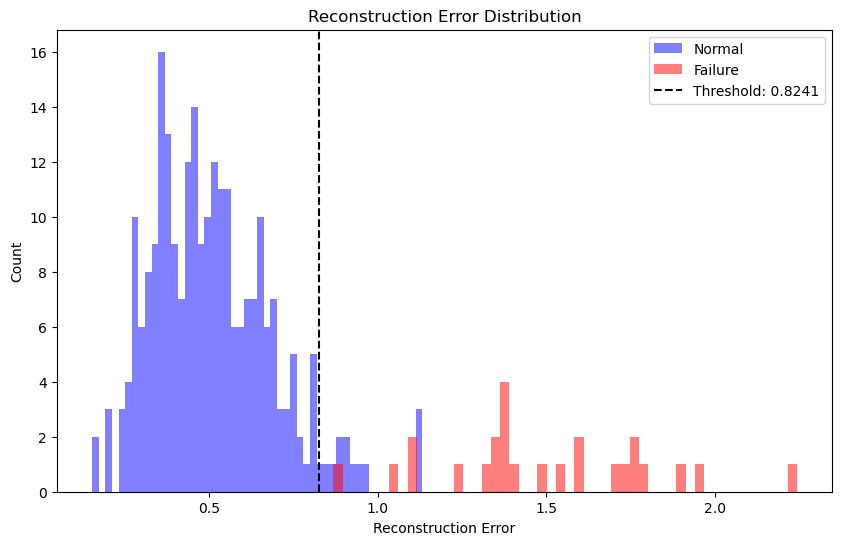

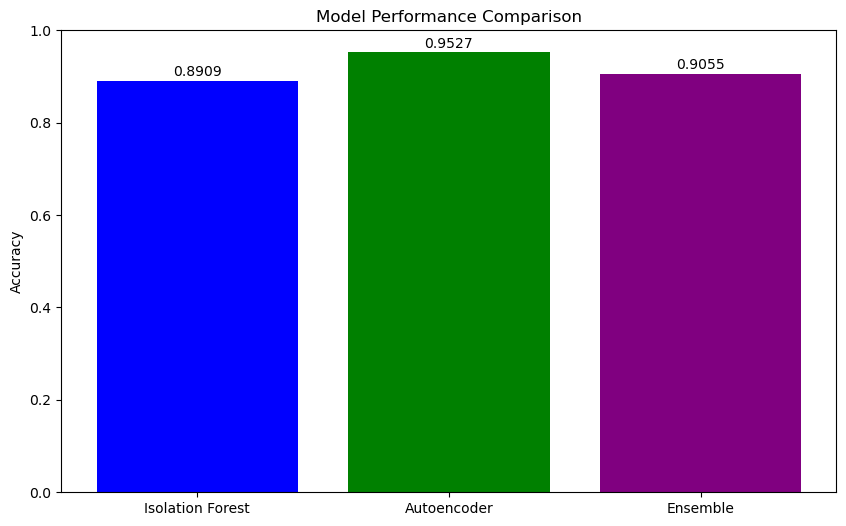

In [12]:
# STEP 7: Visualizing the results
print("\nStep 7: Visualizing the results...")

# Plot reconstruction error distribution
plt.figure(figsize=(10, 6))
reconstructions = autoencoder.predict(X_test_scaled, verbose=0)
mse = np.mean(np.power(X_test_scaled - reconstructions, 2), axis=1)

plt.hist(mse[y_test == 0], bins=50, alpha=0.5, color='blue', label='Normal')
plt.hist(mse[y_test == 1], bins=50, alpha=0.5, color='red', label='Failure')
plt.axvline(x=threshold, color='black', linestyle='--', label=f'Threshold: {threshold:.4f}')
plt.title('Reconstruction Error Distribution')
plt.xlabel('Reconstruction Error')
plt.ylabel('Count')
plt.legend()
plt.savefig('reconstruction_error.png')
print("Saved reconstruction error plot to 'reconstruction_error.png'")

# Plot comparison of model performances
plt.figure(figsize=(10, 6))
models = ['Isolation Forest', 'Autoencoder', 'Ensemble']
accuracies = [isolation_accuracy, autoencoder_accuracy, ensemble_accuracy]
plt.bar(models, accuracies, color=['blue', 'green', 'purple'])
plt.ylabel('Accuracy')
plt.title('Model Performance Comparison')
plt.ylim(0, 1)  # Accuracy ranges from 0 to 1
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f'{acc:.4f}', ha='center')
plt.savefig('model_comparison.png')
print("Saved model comparison plot to 'model_comparison.png'")


In [13]:
# STEP 8: Real-time prediction simulation
print("\nStep 8: Simulating real-time prediction on new data...")

# Create a function that simulates getting new sensor readings
def get_new_sensor_reading(normal=True):
    """Simulate getting new sensor data from the equipment"""
    new_data = np.random.randn(1, num_sensors)
    
    if not normal:  # Simulate a developing problem
        new_data[0, 0] += 2.5  # Temperature rising
        new_data[0, 1] -= 1.8  # Pressure dropping
    
    # Create a DataFrame with the same structure as our training data
    df_new = pd.DataFrame(new_data, columns=sensor_columns)
    
    # Add placeholder values for the time-based features
    for sensor in sensor_columns:
        df_new[f'{sensor}_rolling_mean_10'] = df_new[sensor]
        df_new[f'{sensor}_rate_of_change'] = 0
    
    return df_new[feature_columns]

# Function to make prediction on new data
def predict_equipment_failure(new_data):
    """Predict if equipment is showing signs of failure"""
    # Scale the data
    new_data_scaled = scaler.transform(new_data)
    
    # Get predictions from both models
    isolation_pred = isolation_forest.predict(new_data_scaled)
    isolation_pred = 1 if isolation_pred[0] == -1 else 0
    
    # Get autoencoder prediction
    reconstructions = autoencoder.predict(new_data_scaled, verbose=0)
    mse = np.mean(np.power(new_data_scaled - reconstructions, 2), axis=1)
    autoencoder_pred = 1 if mse[0] > threshold else 0
    
    # Combine predictions
    ensemble_pred = 1 if isolation_pred == 1 or autoencoder_pred == 1 else 0
    
    return {
        'isolation_forest': isolation_pred,
        'autoencoder': autoencoder_pred,
        'ensemble': ensemble_pred,
        'anomaly_score': float(mse[0])
    }

# Simulate normal operation
print("Testing with normal operation data:")
normal_reading = get_new_sensor_reading(normal=True)
normal_prediction = predict_equipment_failure(normal_reading)
print(f"Prediction: {normal_prediction}")
print(f"Is equipment failing? {'Yes' if normal_prediction['ensemble'] == 1 else 'No'}")

# Simulate developing problem
print("\nTesting with abnormal operation data:")
abnormal_reading = get_new_sensor_reading(normal=False)
abnormal_prediction = predict_equipment_failure(abnormal_reading)
print(f"Prediction: {abnormal_prediction}")
print(f"Is equipment failing? {'Yes' if abnormal_prediction['ensemble'] == 1 else 'No'}")

print("\nSimple predictive maintenance system is complete!")


Step 8: Simulating real-time prediction on new data...
Testing with normal operation data:
Prediction: {'isolation_forest': 0, 'autoencoder': 0, 'ensemble': 0, 'anomaly_score': 0.5129935098041546}
Is equipment failing? No

Testing with abnormal operation data:
Prediction: {'isolation_forest': 0, 'autoencoder': 1, 'ensemble': 1, 'anomaly_score': 2.2928464689368147}
Is equipment failing? Yes

Simple predictive maintenance system is complete!
